In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import json
import pandas as pd
import random
from numba import jit
import time
plt.style.use('ggplot')

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/crazyeights/'

In [90]:
num_games = 10000
df_lengths = []   # A list with the number of rows in each data frame
for i in range(num_games):
    df = pd.read_csv(path+'games'+str(i).zfill(5)+'.csv',sep='delimeter',
                     header=None, skiprows=1, engine='python')
    df_lengths.append(len(df))

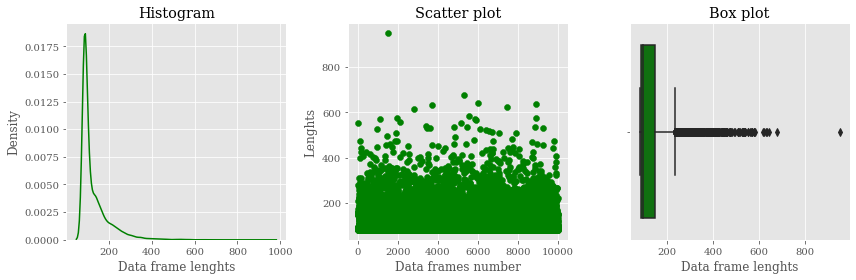

In [91]:
# Length of data frames
fig, ax = plt.subplots(1,3, figsize=(12,4))
sns.kdeplot(df_lengths, color='g', label='Histogram', ax=ax[0]);
ax[0].set_title('Histogram')
ax[0].set_xlabel('Data frame lenghts')
ax[1].scatter(np.arange(10000), df_lengths, color='g', label='Scatter Plot');
ax[1].set_title('Scatter plot')
ax[1].set_ylabel('Lenghts')
ax[1].set_xlabel('Data frames number')
sns.boxplot(x=df_lengths, color='g', ax=ax[2])
ax[2].set_title('Box plot')
ax[2].set_xlabel('Data frame lenghts')
plt.tight_layout()
plt.show()

From the plots we can detect the presence of outliers. We can choose the IQR method and remove data frames with the length (number of rows) greater than $Q3 + 1.5 IQR$ where $Q3$ is the third quartile and $IQR = Q3-Q1$. In this case, all data examples shown in the right hand side in the box plot will be removed.

scatter plots also can help us visualize the ouliers. For example we can just look at the scatter plot and see that we have only about 100 data frames with the number of rows greater than 400 among 10000 data frames. This is almost $1\%$ of data.

The presence of outliers can be also seen from the right skewed density plot.

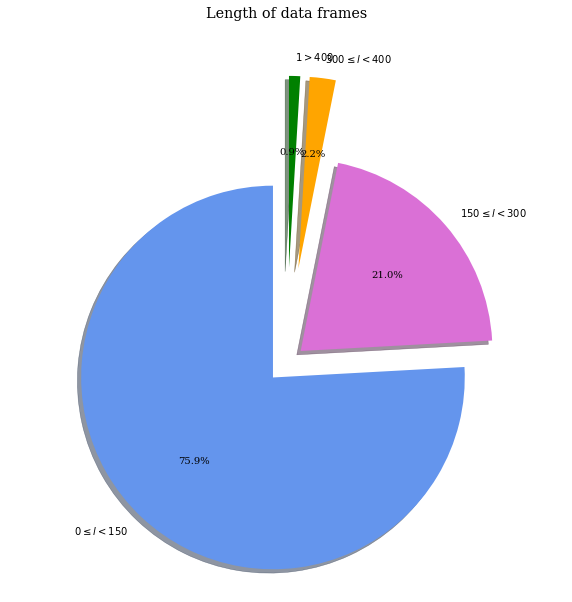

In [92]:
labels = '$0\leq l< 150$', '$150\leq l< 300$', '$300\leq l< 400$', '$1>400$'
percent  = {}
percent[0] = len([i for i in df_lengths if 0<=i<150])
percent[1] = len([i for i in df_lengths if 150<=i<300])
percent[2] = len([i for i in df_lengths if 300<=i<400])
percent[3] = len([i for i in df_lengths if i>=400])

sizes = [percent[i] for i in range(4)]
colors = ['cornflowerblue', 'orchid', 'orange', 'green']
explode = (0.1, 0.1, 0.5, 0.5)
fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, explode=explode, colors=colors, startangle=90)
ax1.axis('equal')  
ax1.set_title('Length of data frames', y=1.05)
plt.show()

From the pi chart we can see that data frames with the number of rows greater than 400  contain only $0.9\%$ of dataset. Therefore, we can consider them as outliers. One way to deal with these outliers is to remove them because working with them is computationally expensive.

In the next cell I have created dictionaries named ncards, neights and game_length. 

For each game  𝑖 ,  𝑛𝑐𝑎𝑟𝑑𝑠[𝑖]  is a list of lists where the first list in that is the number of cards that the winner has in each round of the game, the second list is the number of cards for the player who playes right before the winner plays (left player), the third list is for the one who plays right after the winner plays (right player) and the remaining list is for the other player.

I have specified all losers in a game to see if their statistics are different or not.

𝑛𝑒𝑖𝑔ℎ𝑡𝑠[𝑖] is also a list of lists where the first list in that is the number of cards with 8 on them that the winner has in each round of game $i$, the second list is the number of cards with  8 on them for the left player and so on.

The game_length$[i]$ is also the number of the rounds in game $i$.

In [94]:
def game_stats(num_games):
    ncards, neights, game_length = [{} for i in range(3)]
    winners = []
    i = 0
    for n in range(num_games):
        df = pd.read_csv(path+'games'+str(n).zfill(5)+'.csv',sep='delimeter',
                         header=None, skiprows=1, engine='python')
        if len(df) >= 400: continue   # skip the data frames with length >= 400

      # Find the winner and other players
      # Player who plays right before the winner: lp
      # Player who plays right after the winner: rp
      # Other player: op
        for player in ['PLAYER0', 'PLAYER1',
                        'PLAYER2', 'PLAYER3']:
            if player in df[0][len(df)-1]:
                winner = player
                winners.append(winner) 
                if winner == 'PLAYER0': lp, rp, op = 'PLAYER3', 'PLAYER1', 'PLAYER2'
                elif winner == 'PLAYER1': lp, rp, op = 'PLAYER0', 'PLAYER2', 'PLAYER3'
                elif winner == 'PLAYER2': lp, rp, op = 'PLAYER1', 'PLAYER3', 'PLAYER0'
                else: lp, rp, op = 'PLAYER2', 'PLAYER0', 'PLAYER1'
                break

      # Find the number of cards and eights for each player
        ncards[i], neights[i] = [[[] for i in range(4)] for j in range(2)]
        game_length[i] = 0
        for row_num in range(len(df)-1):
            for j, player in enumerate([winner, lp, rp, op]):
                if player in df[0][row_num] and 'Draws' not in df[0][row_num]:
                    idx = df[0][row_num].index('[')
                    # number of eights
                    neights[i][j].append(df[0][row_num][idx+1:-1].count('8'))
                    # number of cards
                    if df[0][row_num][idx+1:-1] == '': ncards[i][j].append(0)
                    else: ncards[i][j].append(df[0][row_num][idx+1:-1].count(',')+1)
            # The length of the game
            if 'DECK' in df[0][row_num]:
                game_length[i] += 1 
        if  game_length[i]%4 in [0,1]:  
            game_length[i] //= 4
        else:
            game_length[i] = game_length[i]//4 + 1

        i += 1           
    return ncards, neights, game_length, winners     

start = time.time()
ncards, neights, game_length, winners = game_stats(num_games=10000)
end = time.time()
print('Run time: %i sec' %(end-start))

Run time: 85 sec


In [95]:
print('number of cards for 4 players during the first game =\n', ncards[0], '\n')
print('For the winner the number of cards during the first game is =', ncards[0][0], '\n')
print("For the left player, the number of cards during the first game is =", ncards[0][1], '\n')
print("For the right player, the number of cards during the first game is =", ncards[0][2], '\n')
print("For the other player, the number of cards during the first game is =", ncards[0][3])

number of cards for 4 players during the first game =
 [[7, 6, 5, 4, 3, 2, 1, 0], [7, 6, 5, 4, 3, 4, 3], [7, 10, 9, 8, 7, 6, 7], [7, 6, 5, 4, 3, 2, 2]] 

For the winner the number of cards during the first game is = [7, 6, 5, 4, 3, 2, 1, 0] 

For the left player, the number of cards during the first game is = [7, 6, 5, 4, 3, 4, 3] 

For the right player, the number of cards during the first game is = [7, 10, 9, 8, 7, 6, 7] 

For the other player, the number of cards during the first game is = [7, 6, 5, 4, 3, 2, 2]


In [97]:
print('number of eights for 4 players during the first game =\n', neights[0], '\n')
print('For the winner the number of eights during the first game is =', neights[0][0], '\n')
print("For the left player, the number of eights during the first game is =", neights[0][1], '\n')
print("For the right player, the number of eights during the first game is =", neights[0][2], '\n')
print("For the other player, the number of eights during the first game is =", neights[0][3])

number of eights for 4 players during the first game =
 [[2, 2, 2, 2, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]] 

For the winner the number of eights during the first game is = [2, 2, 2, 2, 1, 1, 1, 0] 

For the left player, the number of eights during the first game is = [0, 0, 0, 0, 0, 0, 0] 

For the right player, the number of eights during the first game is = [0, 0, 0, 0, 0, 0, 0] 

For the other player, the number of eights during the first game is = [0, 0, 0, 0, 0, 0, 0]


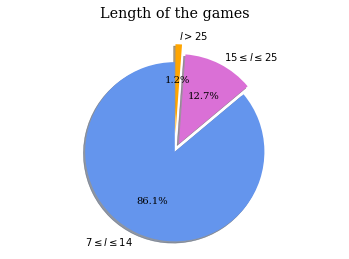

In [98]:
"""Pi chart for distribution of game lengths"""

labels = '$7\leq l\leq 14$', '$15\leq l\leq 25$', '$l>25$'
percent  = {0:0, 1:0, 2:0}
for game in range(len(game_length)):
    if 7 <= game_length[game] <= 14: percent[0] += 1/len(game_length) 
    elif 15 <= game_length[game] <= 25: percent[1] += 1/len(game_length) 
    else: percent[2] += 1/len(ncards)

sizes = [percent[i] for i in range(3)]
explode = (0, 0.1, 0.2) 
colors = ['cornflowerblue', 'orchid', 'orange']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, colors=colors, startangle=90)
ax1.axis('equal')  
ax1.set_title('Length of the games', y=1.05)
plt.show()

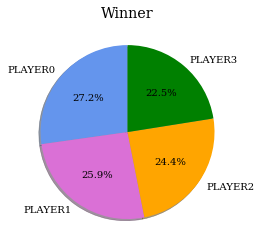

In [99]:
prob = {}
players = ['PLAYER0', 'PLAYER1', 'PLAYER2', 'PLAYER3']
for j, player in enumerate(players):
    prob[j] = winners.count(player) / len(winners)

colors = ['cornflowerblue', 'orchid', 'orange', 'green']
explode = (0, 0, 0, 0)
plt.pie(prob.values(), explode=explode, labels=players, autopct='%1.1f%%',
        shadow=True, colors=colors, startangle=90)
plt.title('Winner')
plt.show()

The above pi chart shows that the first player (PLAYER0) is more likely to win the game and the one who plays last in each round (PLAYER3) is less likely to win a game.

The chance decreases as we go from PLAYER0 to PLAYER3!.

With dictionaries ncards and neights we can find other statistics of the games.

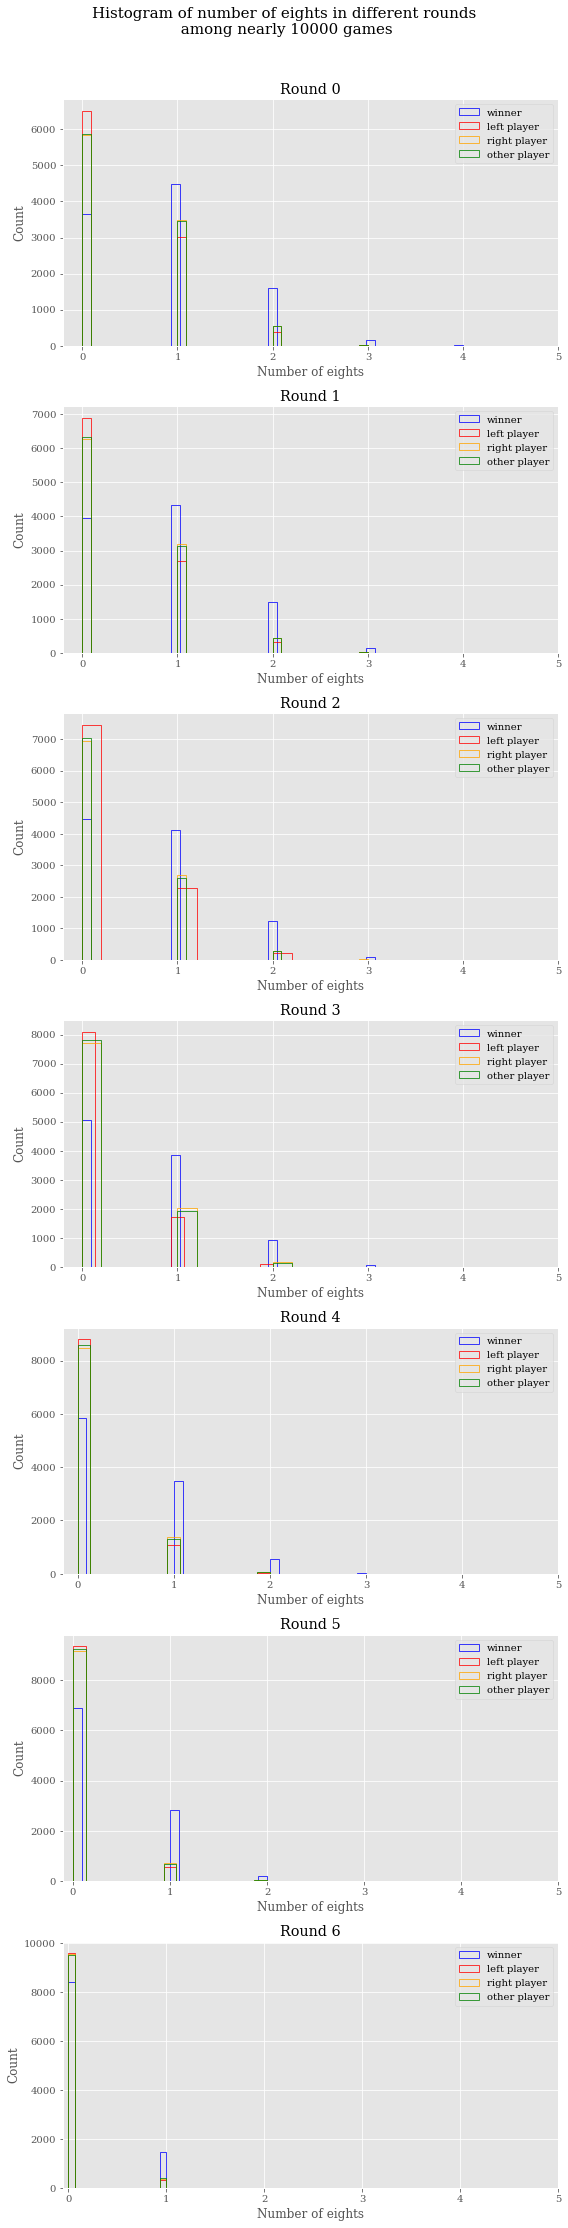

In [101]:
""" number of 8s each player have in different rounds """

labels = 'winner', "left player", "right player", 'other player'
colors = 'blue', 'red', 'orange', 'green'
fig, ax = plt.subplots(7,1, figsize=(8,30))
for round in range(7):
    for player in range(4):
        mylist = [neights[game][player][round] for game in range(len(ncards))]
        sns.histplot(mylist, label=labels[player], fill=False,
                     color=colors[player], ax=ax[round])
    ax[round].set_title('Round %i'  %round)  
    ax[round].legend()
    ax[round].set_xticks(np.linspace(0,5,6))
    ax[round].set_xlabel('Number of eights')
plt.rcParams["font.family"] = "Serif"   
plt.suptitle('Histogram of number of eights in different rounds'
             '\n among nearly 10000 games', y=1.03, size=15) 
plt.tight_layout()  
plt.show()  

Above histograms represent these conditional probabilities: 
$$Pr(\text{number of eights=n} | \text{winner}), Pr(\text{number of eights=n} | \text{left player}), ...$$ 

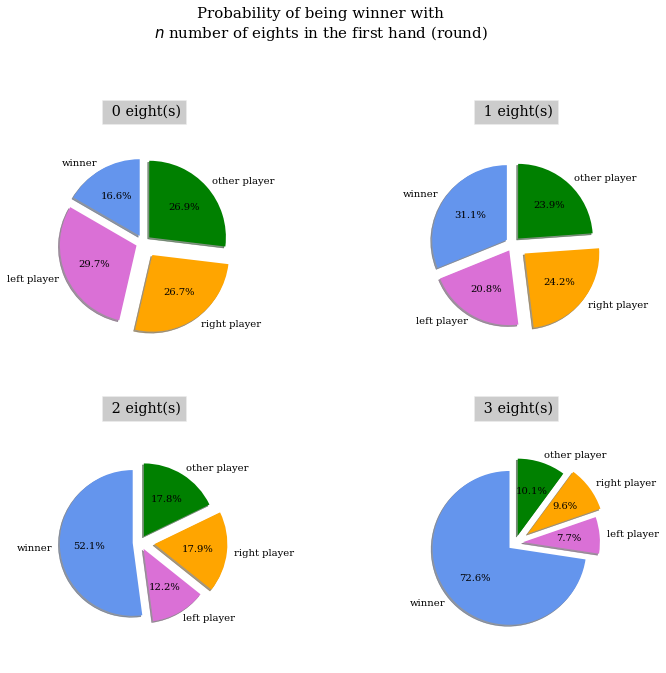

In [102]:
"""probability that a player wins with n number of 8s in the first round"""

fig, axes = plt.subplots(2,2, figsize=(10,10))
labels = 'winner', "left player", "right player", 'other player'
colors = 'cornflowerblue', 'orchid', 'orange', 'green'
explode = (0.1, 0.1, 0.2, 0.1)
num = {i:[0 for j in range(4)] for i in range(4)}

for n in range(4):
    ax = axes[n // 2, n % 2]
    for game in range(len(neights)):
        for player in range(4):
            if neights[game][player][0] == n : num[player][n] += 1
    ax.pie([y[n] for x,y in num.items()], labels=labels, autopct='%1.1f%%',
           shadow=True, explode=explode, colors=colors, startangle=90)
    ax.axis('equal')  
    ax.set_title(' %i eight(s)' %n, bbox={'facecolor':'0.8', 'pad':5})
plt.rcParams["font.family"] = "Serif"   
plt.suptitle('Probability of being winner with\n' 
             '$n$ number of eights in the first hand (round)', y=1.04, size=15)
fig.subplots_adjust(wspace=1)
plt.show()

***Note***: Above pie charts represent these conditional probabilities for a quantity $q$: 
$$Pr(\text{winner} | q), Pr(\text{left player} | q), ...$$ 

For example, the one who has exactly 3 eights in the first round of a game has $73\%$ chance to win that game. In other words, $$Pr( \text{winner} |  \text{3 eights in the first hand})\approx 73\%$$

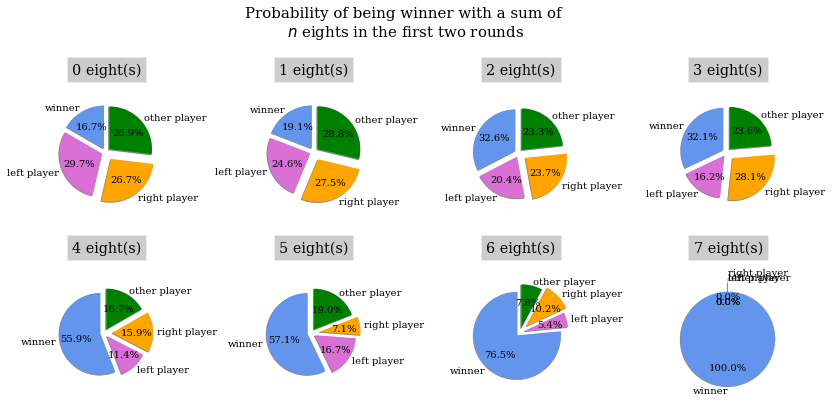

In [105]:
"""probability that a player wins with a sum of n eights in the first two rounds"""

fig, axes = plt.subplots(2,4,figsize=(13,6))
labels = 'winner', "left player", "right player", 'other player'
colors = 'cornflowerblue', 'orchid', 'orange', 'green'
explode = (0.1, 0.1, 0.2, 0.1)
num = {i:[0 for j in range(8)] for i in range(4)}

for n in range(8):
    ax = axes[n // 4, n % 4]
    for game in range(len(neights)):
        for player in range(4):
            if sum(neights[game][player][0:2]) == n : num[player][n] += 1
    ax.pie([y[n] for x,y in num.items()], labels=labels, autopct='%1.1f%%',
          shadow=True, explode=explode, colors=colors, startangle=90)
    ax.axis('equal')  
    ax.set_title('%i eight(s)' %n, bbox={'facecolor':'0.8', 'pad':5})
plt.rcParams["font.family"] = "Serif"   
plt.suptitle('Probability of being winner with a sum of \n' 
             '$n$ eights in the first two rounds', y=1.05, size=15)
fig.subplots_adjust(wspace=1)
plt.show()

***Note***: Above pie charts represent these kind of conditional probabilities for a quantity $q$: 
$$Pr(\text{winner} | q), Pr(\text{left player} | q), ...$$ 

For example, the one who has exactly a sum of 6 eights in the first two rounds of a game has $76.5\%$ chance to win that game. 

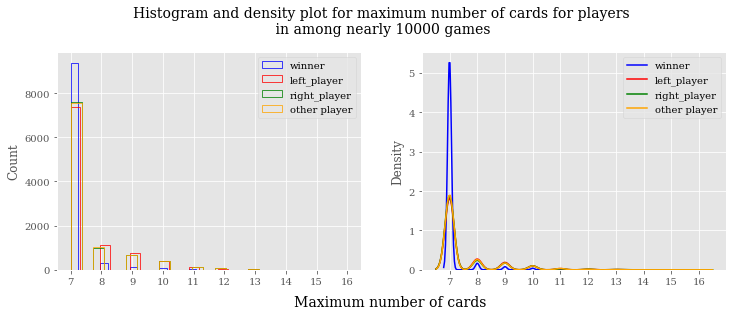

In [106]:
"""maximum number of cards in the hands of players in a game"""

max_cards = {}
labels = 'winner', 'left_player', 'right_player', 'other player' 
colors = 'blue', 'red', 'green', 'orange'

fig, ax = plt.subplots(1,2, figsize=(12,4)) 
for player in range(4):
    max_cards[player] = [max(ncards[game][player]) for game in range(len(ncards))]
    sns.histplot(max_cards[player], label=labels[player],
                 fill=False, color=colors[player], ax=ax[0], bins=25) 
    sns.kdeplot(max_cards[player], label=labels[player], color=colors[player], ax=ax[1])

plt.rcParams["font.family"] = "Serif" 
plt.suptitle('Histogram and density plot for maximum number of cards for players'
              '\n in among nearly 10000 games', y=1.04, size=14)
fig.text(0.4,0, 'Maximum number of cards', size=14)
for n in range(2):
    ax[n].legend()
    ax[n].set_xticks(np.linspace(7,16,10)) 
plt.show()

***Note***: Above histograms represent these conditional probabilities for a quantity $q$: 
$$Pr(q | \text{winner}), Pr(q| \text{left player}), ...$$ 

As we can see from the above plots and also from the plots in the next cells for a quantity $q$ we have :
$$ Pr(q=i | \text{left player})\approx Pr(q=i | \text{right player})\approx Pr(q=i | \text{other player}) $$

For example, let $q=$ maximum number of cards in a game. Then
$$ Pr(q=8 | \text{left player})\approx  Pr(q=8 | \text{right player})\approx  Pr(q=8 | \text{other player}) $$
Also if $q=$ number of 8s in the first round of a game, then
$$ Pr(q=2 | \text{left player})\approx Pr(q=2 | \text{right player})\approx Pr(q=2 | \text{other player}) $$

But from the pie charts in the previous cells it should be clear that 
$ Pr(\text{left player} | q=2)$ can be very different from $Pr(\text{right player}| q=2)$.

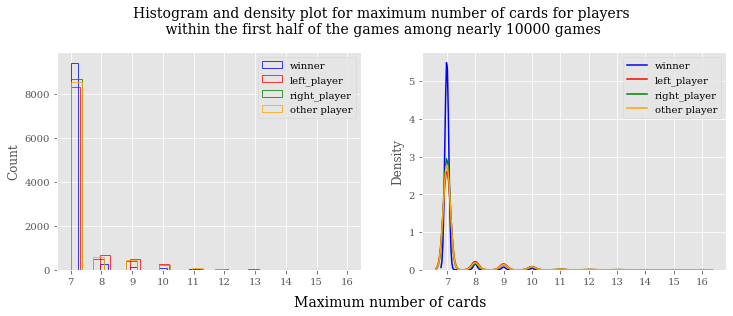

In [107]:
"""maximum number of cards in the hands of players within the first half of the games"""

max_cards = {}
labels = 'winner', 'left_player', 'right_player', 'other player' 
colors = 'blue', 'red', 'green', 'orange'

fig, ax = plt.subplots(1,2, figsize=(12,4)) 
for player in range(4):
    max_cards[player] = [max(ncards[game][player][:len(ncards[game][player])//2])
                         for game in range(len(ncards))]
    sns.histplot(max_cards[player], label=labels[player], fill=False, 
                 color=colors[player], ax=ax[0], bins=25) 
    sns.kdeplot(max_cards[player], label=labels[player], color=colors[player], ax=ax[1])

plt.rcParams["font.family"] = "Serif"   
plt.suptitle('Histogram and density plot for maximum number of cards for players'
            '\n within the first half of the games among nearly 10000 games',
             y=1.04, size=14)
fig.text(0.4,0,'Maximum number of cards', size=14)
for n in range(2):
    ax[n].legend()
    ax[n].set_xticks(np.linspace(7,16,10))
plt.show()
  

***Note***: Above histograms represent these conditional probabilities for a quantity $q$: 
$$Pr(q | \text{winner}), Pr(q| \text{left player}), ...$$ 

Another quantity of interest is the number of draws among players.

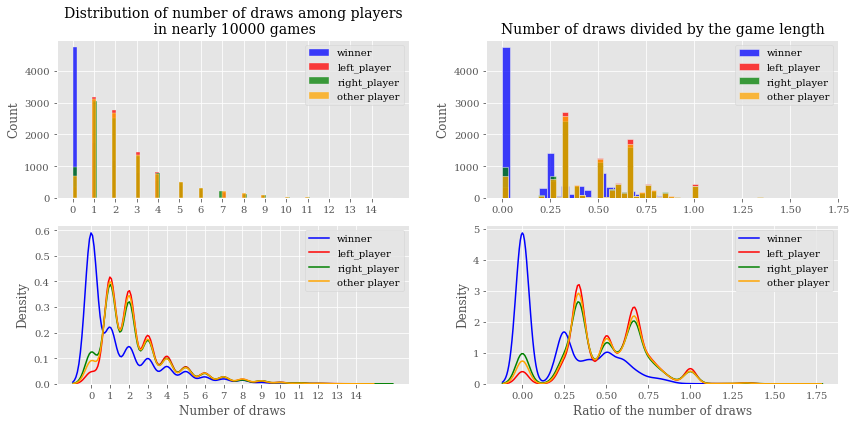

In [109]:
""" comparing the number of draws in a game among players """

def num_draws(l:list):
    count = 0
    for i in range(len(l)-1):
        if l[i+1] >= l[i]: count += 1
    return count  

draws = {}
for game in range(len(ncards)):
    draws[game] = [[] for player in range(4)]
    for player in range(4):
        draws[game][player] = num_draws(ncards[game][player])

fig, ax = plt.subplots(2,2, figsize=(12,6))
for player in range(4):
    ndraws = [draws[game][player] for game in range(len(ncards))]
    ndraws_ratio = [draws[game][player]/(game_length[game]//2) for game in range(len(ncards))]
    sns.histplot(ndraws, label=labels[player], color=colors[player], ax=ax[0,0])  
    sns.histplot(ndraws_ratio, label=labels[player], color=colors[player], ax=ax[0,1])  
    sns.kdeplot(ndraws, label=labels[player], color=colors[player],  ax=ax[1,0])  
    sns.kdeplot(ndraws_ratio, label=labels[player], color=colors[player], ax=ax[1,1])   
ax[0,0].set_title('Distribution of number of draws among players'
                   '\n in nearly 10000 games', size=14) 
ax[1,0].set_xlabel('Number of draws')
ax[0,0].set_xticks(np.linspace(0,14,15))
ax[1,0].set_xticks(np.linspace(0,14,15))
ax[0,1].set_title('Number of draws divided by the game length', size=14) 
ax[1,1].set_xlabel('Ratio of the number of draws')
for n in range(4):
    axes = ax[n//2, n%2]
    axes.legend()
plt.rcParams["font.family"] = "Serif"   
plt.tight_layout()
plt.show()

***Note***: Above histograms represent these conditional probabilities for a quantity $q$: 
$$Pr(q | \text{winner}), Pr(q| \text{left player}), ...$$ 

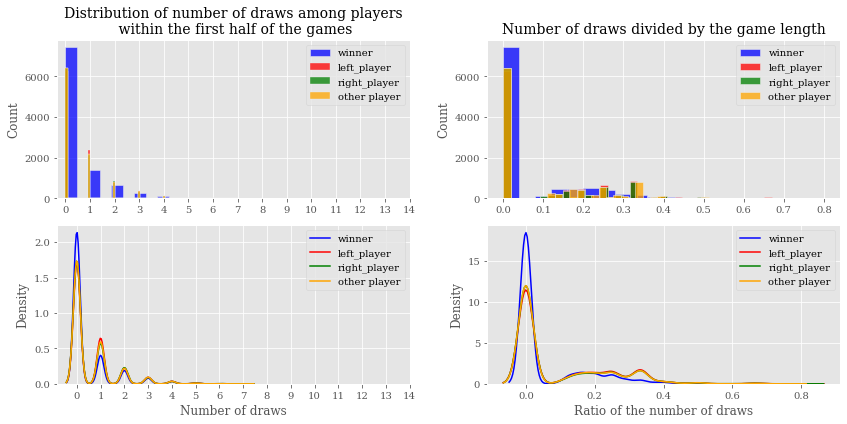

In [110]:
""" comparing the number of draws within the first half of the games among players """

draws = {}
for game in range(len(ncards)):
    draws[game] = [[] for player in range(4)]
    for player in range(4):
        draws[game][player] = num_draws(ncards[game][player][:game_length[game]//2])

fig, ax = plt.subplots(2,2, figsize=(12,6))
for player in range(4):
    ndraws = [draws[game][player] for game in range(len(ncards))]
    ndraws_ratio = [draws[game][player]/(game_length[game]//2) for game in range(len(ncards))]
    sns.histplot(ndraws, label=labels[player], color=colors[player],  ax=ax[0,0])  
    sns.histplot(ndraws_ratio, label=labels[player], color=colors[player], ax=ax[0,1])  
    sns.kdeplot(ndraws, label=labels[player], color=colors[player],  ax=ax[1,0])  
    sns.kdeplot(ndraws_ratio, label=labels[player], color=colors[player], ax=ax[1,1]) 
ax[0,0].set_title('Distribution of number of draws among players'
                   '\n within the first half of the games', size=14) 
ax[1,0].set_xlabel('Number of draws')
ax[0,0].set_xticks(np.linspace(0,14,15))
ax[1,0].set_xticks(np.linspace(0,14,15))
ax[0,1].set_title('Number of draws divided by the game length', size=14) 
ax[1,1].set_xlabel('Ratio of the number of draws')
for n in range(4):
    axes = ax[n//2, n%2]
    axes.legend()
plt.rcParams["font.family"] = "Serif"   
plt.tight_layout()
plt.show()

***Note***: Above histograms represent these conditional probabilities for a quantity $q$: 
$$Pr(q | \text{winner}), Pr(q| \text{left player}), ...$$ 

***Additional Analysis:*** 

Another concept for analysis could be the variety of hands. For this concept someone can define a similarity measure for the cards of two players in each round of a game. For example, if in some games and some rounds PLAYER0 has [AS, 8H] and PLAYER1 has [6D, 8D, JS], then similarity of two sets is 2 because both have 8 and S in common. In this definition the similarity of a player with themselves is simply a measure for variety of suits and values in the hands of that player.

Intuition behind this measure is that if one player has more diversity in cards and suits in one round, it might be less likely for them to draw from the deck.

In [112]:
def similarity(s1:set, s2:set):
    return len(s1&s2)

sim_df = {}
win = []
iter = 0
for n in range(10000):
    df = pd.read_csv(path+'games'+str(n).zfill(5)+'.csv',
                     sep='delimeter', header=None, skiprows=1, engine='python')
    if len(df) >= 400: continue
  
    for row in range(len(df)):
        for char in ['DECK', 'DISCARD', 'PLAYER0', 'PLAYER1',
                     'PLAYER2', 'PLAYER3', 'Draws', 'None', '[', ']']:
            df[0][row] = df[0][row].replace(char,'')

    rows_list = ['DECK', 'PLAYER0', 'PLAYER1',
                'PLAYER2', 'PLAYER3', 'DISCARD']
    dic = {}
    for row, row_name in enumerate(rows_list):
        x = ''
        for char in df[0][row]:
            if char in [',', '']: continue
            else:  x += char  
      
        dic[row_name] = set([s for s in x])
        if '0' in dic[row_name]: 
            dic[row_name].remove('0')
            dic[row_name].remove('1')
            dic[row_name].add('10')

    sim_df[iter] = pd.DataFrame(columns=rows_list, index=rows_list) 
    for a in rows_list:
        for b in rows_list:
            sim_df[iter].loc[a,b] = similarity(dic[a], dic[b])
    iter += 1    
    

In [80]:
print('Dataframes for similarity of cards:', '\n')
for i in range(10):
    print(sim_df[i],'\n')
    print(winners[i],'wins','\n','-'*50)

Dataframes for similarity of cards: 

        DECK PLAYER0 PLAYER1 PLAYER2 PLAYER3 DISCARD
DECK      15       9       5      10       8       2
PLAYER0    9      10       3       7       6       1
PLAYER1    5       3       7       4       5       0
PLAYER2   10       7       4      11       8       1
PLAYER3    8       6       5       8      10       1
DISCARD    2       1       0       1       1       2 

PLAYER0 wins 
 --------------------------------------------------
        DECK PLAYER0 PLAYER1 PLAYER2 PLAYER3 DISCARD
DECK      17      11      10      10      10       2
PLAYER0   11      11       7       6       7       2
PLAYER1   10       7      10       6       5       1
PLAYER2   10       6       6      10       6       1
PLAYER3   10       7       5       6      10       2
DISCARD    2       2       1       1       2       2 

PLAYER0 wins 
 --------------------------------------------------
        DECK PLAYER0 PLAYER1 PLAYER2 PLAYER3 DISCARD
DECK      17      10      10   

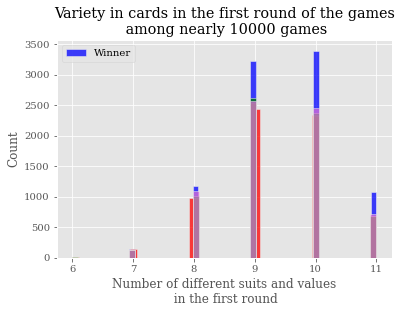

In [ ]:
win_sim = [sim_df[i].loc[winners[i], winners[i]] for i in range(9000)]

players = ['PLAYER0', 'PLAYER1', 'PLAYER2', 'PLAYER3'] 
lists = [[] for i in range(4)]
los_sim = dict(zip(players, lists))

for i in range(len(winners)):
    for loser in set(players)-{winners[i]}:
        los_sim[loser].append(sim_df[i].loc[loser, loser])

colors = ['blue', 'red', 'orange', 'green', 'orchid'] 
labels = ['Winner']
sns.histplot(win_sim, color=colors[0], label=labels[0])
for j in range(4):
    sns.histplot(los_sim['PLAYER'+str(j)], color=colors[j+1])
plt.rcParams["font.family"] = "Serif"    
plt.title('Variety in cards in the first round of the games'
          '\n among nearly 10000 games')
plt.xlabel('Number of different suits and values'
           '\n in the first round')  
plt.legend()  
plt.show()

***Note***: Above histogram represents these conditional probabilities for a quantity $q$: 
$$Pr(q | \text{winner}), Pr(q| \text{left player}), ...$$ 